# Efficiency plots v49

In this NB I use v49 of the training (shallow, 100 epochs) to plot:

- Effiency by the total number of jets in the event
- Efficiency by pt of the particle (normal binning and dynamic binning)
- Efficiency by eta for the Higgs only
- Efficiency by pt for b1 and b2 of the Higgs
- Efficiencies of ttH together
- Efficiency by pt with errorbars

These are the plots I used in my presentation.

## Initialise

In [4]:
import h5py
import awkward as ak
import pandas as pd
import vector
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep as hep
from matplotlib.colors import LogNorm
hep.style.use(hep.style.ROOT)
mpl.rcParams['figure.dpi'] = 50
vector.register_awkward()

In [5]:
df = h5py.File('./SPANet/predictions/0405_output_v49_matched.h5','r')
df_input = h5py.File('./SPANet/data/tth_matched_3.h5','r')

In [6]:
df_jets = ak.from_parquet("/eos/user/d/dvalsecc/www/ttHbbAnalysis/training_dataset/all_jets_v6.parquet")
(jets,
partons_matched,
partons,
generator_info,
lepton_partons,
lepton_reco, 
met
) = ak.unzip(df_jets)
jets = ak.with_name(jets, name="Momentum4D")

In [7]:
# Get fully matched jets from df_jets
mask_fullymatched = ak.sum(jets.matched == True, axis=1)>=6
higgs = jets[jets.prov == 1]
jets = jets[ak.num(higgs) == 2]

w_or_t_jets = jets[(jets.prov == 5)|(jets.prov == 2)]
jets = jets[ak.num(w_or_t_jets) == 3]

lep_top = jets[jets.prov == 3]
jets = jets[ak.num(lep_top) == 1]

Maximum number of jets is 14


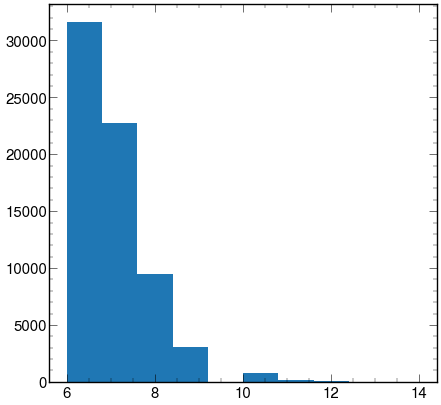

In [8]:
plt.hist(ak.num(jets));
print(f"Maximum number of jets is {max(ak.num(jets))}")

In [1]:
# Define some functions

In [9]:
def get_leptop_arrays(n, njets, mode="partial"):

    # Leptonic top jets
    t2_b_pred = ak.Array(df["TARGETS"]["t2"]["b"][()])
    t2_b_pred = ak.unflatten(t2_b_pred, ak.ones_like(t2_b_pred))

    t2_b_true = ak.Array(df_input["TARGETS"]["t2"]["b"][()])
    t2_b_true = ak.unflatten(t2_b_true, ak.ones_like(t2_b_true))
    
    leptop_index_pred = t2_b_pred
    leptop_index_true = t2_b_true
    
    if mode == "partial":
        leptop_index_pred = leptop_index_pred[ak.num(jets)==n]
        leptop_index_true = leptop_index_true[ak.num(jets)==n]

    leptop_jet_pred = njets[leptop_index_pred]
    leptop_jet_true = njets[leptop_index_true]

    mask = (leptop_jet_true == leptop_jet_pred)
    leptop_pred_correct = leptop_jet_pred[mask] # correctly predicted jets
    leptop_pred_wrong = leptop_jet_pred[~mask] # wrongly predicted jets

    leptop_pred_correct = leptop_pred_correct[ak.num(leptop_pred_correct)>0]
    leptop_pred_wrong = leptop_pred_wrong[ak.num(leptop_pred_wrong)>0]

    return leptop_pred_correct, leptop_pred_wrong

def get_higgs_arrays(n, njets, mode="partial"):
    
    H_b1_true = ak.Array(df_input["TARGETS"]["h"]["b1"][()])
    H_b2_true = ak.Array(df_input["TARGETS"]["h"]["b2"][()])

    H_b1_true = ak.unflatten(H_b1_true, ak.ones_like(H_b1_true))
    H_b2_true = ak.unflatten(H_b2_true, ak.ones_like(H_b2_true))

    H_b1_pred = ak.Array(df["TARGETS"]["h"]["b1"][()])
    H_b2_pred = ak.Array(df["TARGETS"]["h"]["b2"][()])
    
    H_b1_pred = ak.unflatten(H_b1_pred, ak.ones_like(H_b1_pred))
    H_b2_pred = ak.unflatten(H_b2_pred, ak.ones_like(H_b2_pred))
 
    higgs_index_true = ak.concatenate((H_b1_true, H_b2_true), axis=1)
    higgs_index_pred = ak.concatenate((H_b1_pred, H_b2_pred), axis=1)
    
    if mode == "partial":
        higgs_index_true = higgs_index_true[ak.num(jets)==n]
        higgs_index_pred = higgs_index_pred[ak.num(jets)==n]

    higgs_jet_true = njets[higgs_index_true]
    higgs_jet_pred = njets[higgs_index_pred]
        
    mask = (higgs_jet_true == higgs_jet_pred)
    higgs_pred_correct = higgs_jet_pred[mask] # correctly predicted jets
    higgs_pred_wrong = higgs_jet_pred[~mask] # wrongly predicted jets

    higgs_pred_correct = higgs_pred_correct[ak.num(higgs_pred_correct)==2]
    higgs_pred_wrong = higgs_pred_wrong[ak.num(higgs_pred_wrong)>0]

    return higgs_pred_correct, higgs_pred_wrong

def get_hadtop_arrays(n, njets, mode="partial"):
    
    t1_q1_true = ak.Array(df_input["TARGETS"]["t1"]["q1"][()])
    t1_q2_true = ak.Array(df_input["TARGETS"]["t1"]["q2"][()])
    t1_b_true = ak.Array(df_input["TARGETS"]["t1"]["b"][()])

    t1_q1_true = ak.unflatten(t1_q1_true, ak.ones_like(t1_q1_true))
    t1_q2_true = ak.unflatten(t1_q2_true, ak.ones_like(t1_q2_true))
    t1_b_true = ak.unflatten(t1_b_true, ak.ones_like(t1_b_true))
    
    t1_q1_pred = ak.Array(df["TARGETS"]["t1"]["q1"][()])
    t1_q2_pred = ak.Array(df["TARGETS"]["t1"]["q2"][()])
    t1_b_pred = ak.Array(df["TARGETS"]["t1"]["b"][()])
    
    t1_q1_pred = ak.unflatten(t1_q1_pred, ak.ones_like(t1_q1_pred))
    t1_q2_pred = ak.unflatten(t1_q2_pred, ak.ones_like(t1_q2_pred))
    t1_b_pred = ak.unflatten(t1_b_pred, ak.ones_like(t1_b_pred))
 
    hadtop_index_true = ak.concatenate((t1_q1_true, t1_q2_true, t1_b_true), axis=1)
    hadtop_index_pred = ak.concatenate((t1_q1_pred, t1_q2_pred, t1_b_pred), axis=1)
    
    if mode == "partial":
        hadtop_index_true = hadtop_index_true[ak.num(jets)==n]
        hadtop_index_pred = hadtop_index_pred[ak.num(jets)==n]

    hadtop_jet_true = njets[hadtop_index_true]
    hadtop_jet_pred = njets[hadtop_index_pred]
        
    mask = (hadtop_jet_true == hadtop_jet_pred)
    hadtop_pred_correct = hadtop_jet_pred[mask] # correctly predicted jets
    hadtop_pred_wrong = hadtop_jet_pred[~mask] # wrongly predicted jets

    hadtop_pred_correct = hadtop_pred_correct[ak.num(hadtop_pred_correct)==3]
    hadtop_pred_wrong = hadtop_pred_wrong[ak.num(hadtop_pred_wrong)>0]

    return hadtop_pred_correct, hadtop_pred_wrong

def calculate_efficiency(particle, n, njets, mode="partial"):
    if particle == "h":
        pred_correct, pred_wrong = get_higgs_arrays(n, njets, mode)
    if particle == "t1":
        pred_correct, pred_wrong = get_hadtop_arrays(n, njets, mode)
    if particle == "t2":
        pred_correct, pred_wrong = get_leptop_arrays(n, njets, mode)
    print(f"\nNumber of correctly predicted within {n} jets is {len(pred_correct)}")
    print(f"Number of wrongly predicted within {n} jets is {len(pred_wrong)}")
    print(f"Total within {n} jets is {len(njets)}")
    
    purity = len(pred_correct)/len(njets)
    print(f"{n}-jet efficiency is {purity:.3f}")
    
    return pred_correct, pred_wrong

def get_purities_by_njets(name, njet_min, njet_max):
    purities = []
    errors = []

    for n in range(njet_min, njet_max+1):
        pred_correct, pred_wrong = calculate_efficiency(name, n, jets[ak.num(jets)==n])
        all_counts = len(pred_correct) + len(pred_wrong)
        purity = len(pred_correct) / all_counts
        error_purity = np.sqrt(purity * (1-purity) / all_counts)
        purities.append(purity)
        errors.append(error_purity)

    n = "all"
    pred_correct, pred_wrong = calculate_efficiency(name, n, jets, mode="full")
    all_counts = len(pred_correct) + len(pred_wrong)
    purity = len(pred_correct) / all_counts
    error_purity = np.sqrt(purity * (1-purity) / all_counts)
    purities.append(purity)
    errors.append(error_purity)

    return purities, errors

## Effiency by njets

Plot the efficiency for the different particles for different number of jets. This should be the same as the table, which is:

![matched_purities_v49.png](matched_purities_v49.png)

### Leptonic top

In [12]:
purities, errors = get_purities_by_njets("t2", 6, 14)
leptop_purities = purities
leptop_errors = errors


Number of correctly predicted within 6 jets is 21533
Number of wrongly predicted within 6 jets is 10063
Total within 6 jets is 31596
6-jet efficiency is 0.682

Number of correctly predicted within 7 jets is 14775
Number of wrongly predicted within 7 jets is 7999
Total within 7 jets is 22774
7-jet efficiency is 0.649

Number of correctly predicted within 8 jets is 5975
Number of wrongly predicted within 8 jets is 3483
Total within 8 jets is 9458
8-jet efficiency is 0.632

Number of correctly predicted within 9 jets is 1845
Number of wrongly predicted within 9 jets is 1187
Total within 9 jets is 3032
9-jet efficiency is 0.609

Number of correctly predicted within 10 jets is 499
Number of wrongly predicted within 10 jets is 316
Total within 10 jets is 815
10-jet efficiency is 0.612

Number of correctly predicted within 11 jets is 102
Number of wrongly predicted within 11 jets is 56
Total within 11 jets is 158
11-jet efficiency is 0.646

Number of correctly predicted within 12 jets is 19


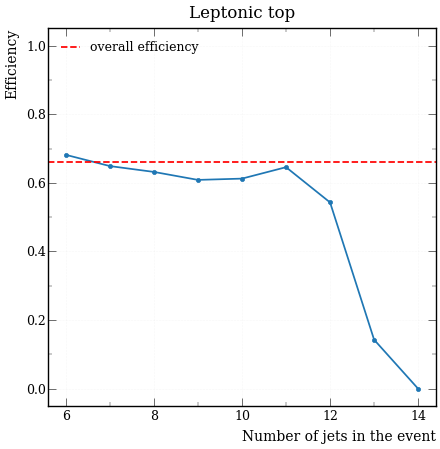

In [13]:
n = [6,7,8,9,10,11,12,13,14]

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

fig, ax = plt.subplots(1, 1)

plt.plot(n, purities[:-1], marker='o', lw=2.5)
plt.axhline(purities[-1], label="overall efficiency", c='r', ls="--", lw=2.5)

plt.xlabel("Number of jets in the event", fontsize=20, labelpad=10)
plt.ylabel("Efficiency", fontsize=20, labelpad=10)
plt.title("Leptonic top", fontsize=24, pad=15)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.05,1.05)

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))

plt.legend(fontsize=18, loc="upper left")
plt.grid(alpha=0.2, zorder=0)
#plt.show()
plt.rcParams['figure.facecolor'] = 'white'
plt.savefig("./efficiency_plots/t2_eff_vs_njets.png", transparent=False, dpi=300,
            bbox_inches='tight')

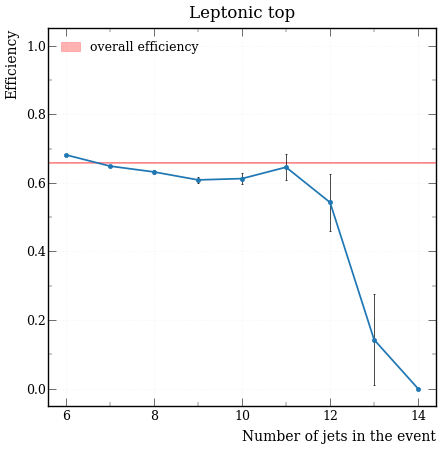

In [59]:
n = [6,7,8,9,10,11,12,13,14]

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

fig, ax = plt.subplots(1, 1)

plt.errorbar(n, purities[:-1], errors[:-1], marker='o', lw=2.5,
             ecolor='k', elinewidth=1, capsize=1.6)
plt.axhspan(purities[-1] + errors[-1], purities[-1], color='r', alpha=0.3,
            label="overall efficiency")
plt.axhspan(purities[-1] - errors[-1], purities[-1], color='r', alpha=0.3)

plt.xlabel("Number of jets in the event", fontsize=20, labelpad=10)
plt.ylabel("Efficiency", fontsize=20, labelpad=10)
plt.title("Leptonic top", fontsize=24, pad=15)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.05,1.05)

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))

plt.legend(fontsize=18, loc="upper left")
plt.grid(alpha=0.2, zorder=0)
#plt.show()
plt.rcParams['figure.facecolor'] = 'white'
plt.savefig("./efficiency_plots/t2_eff_vs_njets_errors.png", transparent=False, dpi=300,
            bbox_inches='tight')

### Higgs

In [14]:
purities, errors = get_purities_by_njets("h", 6, 14)
higgs_purities = purities
higgs_errors = errors


Number of correctly predicted within 6 jets is 18821
Number of wrongly predicted within 6 jets is 12775
Total within 6 jets is 31596
6-jet efficiency is 0.596

Number of correctly predicted within 7 jets is 12404
Number of wrongly predicted within 7 jets is 10370
Total within 7 jets is 22774
7-jet efficiency is 0.545

Number of correctly predicted within 8 jets is 4969
Number of wrongly predicted within 8 jets is 4489
Total within 8 jets is 9458
8-jet efficiency is 0.525

Number of correctly predicted within 9 jets is 1484
Number of wrongly predicted within 9 jets is 1548
Total within 9 jets is 3032
9-jet efficiency is 0.489

Number of correctly predicted within 10 jets is 382
Number of wrongly predicted within 10 jets is 433
Total within 10 jets is 815
10-jet efficiency is 0.469

Number of correctly predicted within 11 jets is 76
Number of wrongly predicted within 11 jets is 82
Total within 11 jets is 158
11-jet efficiency is 0.481

Number of correctly predicted within 12 jets is 17


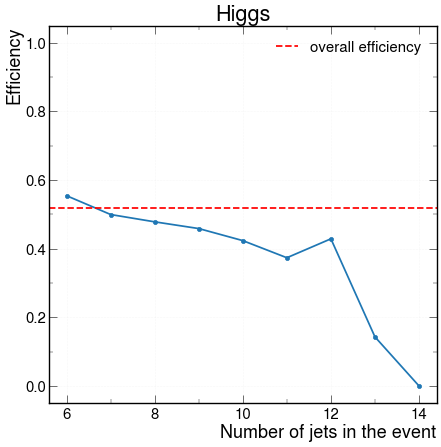

In [63]:
n = [6,7,8,9,10,11,12,13,14]

fig, ax = plt.subplots(1, 1)
plt.plot(n, purities[:-1], marker='o', linewidth=2.5)
plt.axhline(purities[-1], label="overall efficiency", color='r', linestyle="--",
           linewidth=2.5)
plt.xlabel("Number of jets in the event")
plt.ylabel("Efficiency")
plt.title("Higgs")
plt.ylim(-0.05,1.05)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
plt.legend()
plt.grid(alpha=0.2, zorder=0)
#plt.show()
plt.rcParams['figure.facecolor'] = 'white'
plt.savefig("./efficiency_plots/h_eff_vs_njets.png", transparent=False, dpi=300, bbox_inches='tight')

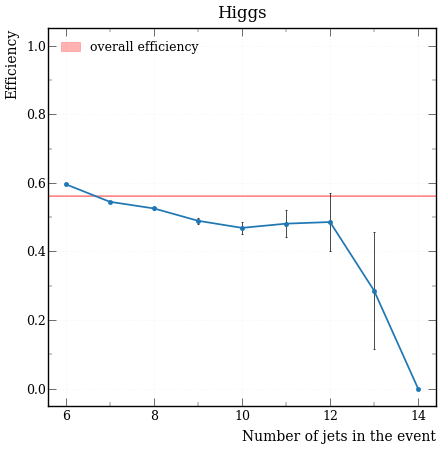

In [61]:
n = [6,7,8,9,10,11,12,13,14]

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

fig, ax = plt.subplots(1, 1)

plt.errorbar(n, purities[:-1], errors[:-1], marker='o', lw=2.5,
             ecolor='k', elinewidth=1, capsize=1.6)
plt.axhspan(purities[-1] + errors[-1], purities[-1], color='r', alpha=0.3,
            label="overall efficiency")
plt.axhspan(purities[-1] - errors[-1], purities[-1], color='r', alpha=0.3)

plt.xlabel("Number of jets in the event", fontsize=20, labelpad=10)
plt.ylabel("Efficiency", fontsize=20, labelpad=10)
plt.title("Higgs", fontsize=24, pad=15)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.05,1.05)

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))

plt.legend(fontsize=18, loc="upper left")
plt.grid(alpha=0.2, zorder=0)
#plt.show()
plt.rcParams['figure.facecolor'] = 'white'
plt.savefig("./efficiency_plots/h_eff_vs_njets_errors.png", transparent=False, dpi=300,
            bbox_inches='tight')

### Hadronic top

In [15]:
purities, errors = get_purities_by_njets("t1", 6, 14)
hadtop_purities = purities
hadtop_errors = errors


Number of correctly predicted within 6 jets is 22203
Number of wrongly predicted within 6 jets is 9393
Total within 6 jets is 31596
6-jet efficiency is 0.703

Number of correctly predicted within 7 jets is 13896
Number of wrongly predicted within 7 jets is 8878
Total within 7 jets is 22774
7-jet efficiency is 0.610

Number of correctly predicted within 8 jets is 5135
Number of wrongly predicted within 8 jets is 4323
Total within 8 jets is 9458
8-jet efficiency is 0.543

Number of correctly predicted within 9 jets is 1416
Number of wrongly predicted within 9 jets is 1616
Total within 9 jets is 3032
9-jet efficiency is 0.467

Number of correctly predicted within 10 jets is 350
Number of wrongly predicted within 10 jets is 465
Total within 10 jets is 815
10-jet efficiency is 0.429

Number of correctly predicted within 11 jets is 65
Number of wrongly predicted within 11 jets is 93
Total within 11 jets is 158
11-jet efficiency is 0.411

Number of correctly predicted within 12 jets is 14
Nu

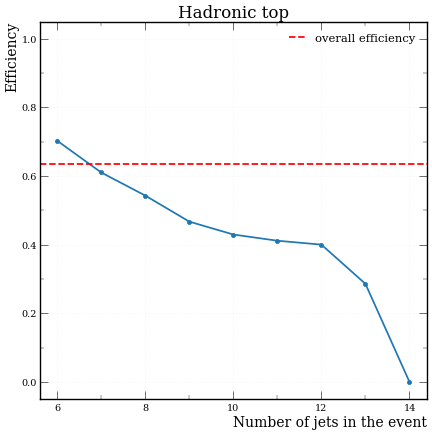

In [65]:
n = [6,7,8,9,10,11,12,13,14]

fig, ax = plt.subplots(1, 1)
plt.plot(n, purities[:-1], marker='o', linewidth=2.5)
plt.axhline(0.635, label="overall efficiency", color='r', linestyle="--",
           linewidth=2.5)
plt.xlabel("Number of jets in the event")
plt.ylabel("Efficiency")
plt.title("Hadronic top")
plt.ylim(-0.05,1.05)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
plt.legend()
plt.grid(alpha=0.2, zorder=0)
#plt.show()
plt.rcParams['figure.facecolor'] = 'white'
plt.savefig("./efficiency_plots/t1_eff_vs_njets.png", transparent=False, dpi=300, bbox_inches='tight')

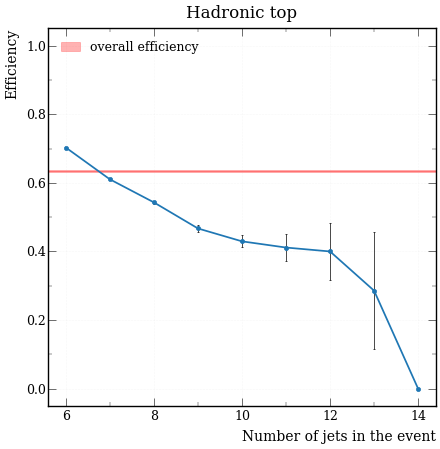

In [63]:
n = [6,7,8,9,10,11,12,13,14]

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

fig, ax = plt.subplots(1, 1)

plt.errorbar(n, purities[:-1], errors[:-1], marker='o', lw=2.5,
             ecolor='k', elinewidth=1, capsize=1.6)
plt.axhspan(purities[-1] + errors[-1], purities[-1], color='r', alpha=0.3,
            label="overall efficiency")
plt.axhspan(purities[-1] - errors[-1], purities[-1], color='r', alpha=0.3)

plt.xlabel("Number of jets in the event", fontsize=20, labelpad=10)
plt.ylabel("Efficiency", fontsize=20, labelpad=10)
plt.title("Hadronic top", fontsize=24, pad=15)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.05,1.05)

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))

plt.legend(fontsize=18, loc="upper left")
plt.grid(alpha=0.2, zorder=0)
#plt.show()
plt.rcParams['figure.facecolor'] = 'white'
plt.savefig("./efficiency_plots/t1_eff_vs_njets_errors.png", transparent=False, dpi=300,
            bbox_inches='tight')

## Higgs efficiency by pt

In [16]:
H_b1_true = ak.Array(df_input["TARGETS"]["h"]["b1"][()])
H_b2_true = ak.Array(df_input["TARGETS"]["h"]["b2"][()])

H_b1_true = ak.unflatten(H_b1_true, ak.ones_like(H_b1_true))
H_b2_true = ak.unflatten(H_b2_true, ak.ones_like(H_b2_true))

H_b1_pred = ak.Array(df["TARGETS"]["h"]["b1"][()])
H_b2_pred = ak.Array(df["TARGETS"]["h"]["b2"][()])

H_b1_pred = ak.unflatten(H_b1_pred, ak.ones_like(H_b1_pred))
H_b2_pred = ak.unflatten(H_b2_pred, ak.ones_like(H_b2_pred))

higgs_index_true = ak.concatenate((H_b1_true, H_b2_true), axis=1)
higgs_index_pred = ak.concatenate((H_b1_pred, H_b2_pred), axis=1)

higgs_jet_true = jets[higgs_index_true]
higgs_jet_pred = jets[higgs_index_pred]

In [52]:
higgs_jet_true

<MomentumArray4D [[{pt: 126, eta: 2.37, ... prov: 1}]] type='67876 * var * Momen...'>

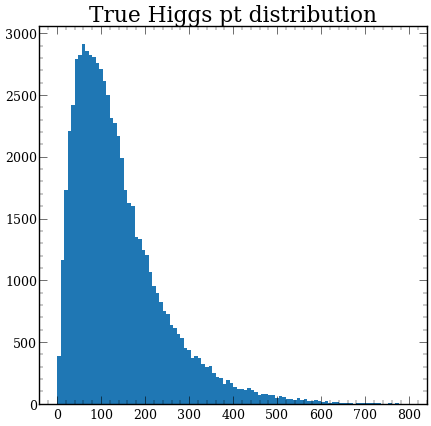

In [17]:
plt.hist((higgs_jet_true[:,0] + higgs_jet_true[:,1]).pt, bins=100, range=(0,800))
plt.title("True Higgs pt distribution");

In [18]:
higgs_true_pt = (higgs_jet_true[:,0] + higgs_jet_true[:,1]).pt
higgs_pred_pt = (higgs_jet_pred[:,0] + higgs_jet_pred[:,1]).pt
higgs_true_pt

<Array [166, 161, 189, 394, ... 276, 209, 106] type='67876 * float32'>

In [55]:
higgs_pred_pt

<Array [166, 161, 108, ... 276, 99.2, 48.3] type='67876 * float32'>

In [19]:
def find_bin(value, bins):
    """ bins is a list of tuples, like [(0,20), (20, 40), (40, 60)],
        binning returns the smallest index i of bins so that
        bin[i][0] <= value < bin[i][1]
    """
    for i in range(0, len(bins)):
        if bins[i][0] <= value < bins[i][1]:
            return i
    return -1

def create_bins(lower_bound, width, quantity):
    """ create_bins returns an equal-width (distance) partitioning. 
        It returns an ascending list of tuples, representing the intervals.
        A tuple bins[i], i.e. (bins[i][0], bins[i][1])  with i > 0 
        and i < quantity, satisfies the following conditions:
            (1) bins[i][0] + width == bins[i][1]
            (2) bins[i-1][0] + width == bins[i][0] and
                bins[i-1][1] + width == bins[i][1]
    """
    bins = []
    for low in range(lower_bound, lower_bound + quantity*width + 1, width):
        bins.append((low, low+width))
    return bins

In [20]:
def pt_efficiency(true_pt, pred_pt, nbins, binwidth):
    
    # Bin the array of predicted pts
    data = pd.DataFrame({"pt": pred_pt})

    bins = create_bins(lower_bound=0, width=binwidth, quantity=nbins)
    bin_means = []
    for i in range(len(bins)):
        bin_means.append((bins[i][0] + bins[i][1])/2)

    bins = pd.IntervalIndex.from_tuples(bins)
    data['pt_bin'] = pd.cut(data['pt'], bins=bins)
    
    # Find all counts (correctly and wrongly predicted -- denominator of efficiency)
    a = data['pt_bin'].value_counts(sort=False)
    a.index = a.index.astype(str)
    a = a.to_dict()
    all_counts = np.array(list(a.values()))
    
    # Construct correctly predicted and wrongly predicted jet pts
    mask = (true_pt == pred_pt)

    # Find counts of correctly predicted events
    data['correct'] = mask
    data = data[data['correct']==True]
    c = data['pt_bin'].value_counts(sort=False)
    c.index = c.index.astype(str)
    c = c.to_dict()
    correct_counts = np.array(list(c.values()))

    # Find the efficiency for each interval
    bin_efficiency = np.zeros(len(correct_counts))

    for i in range(len(all_counts)):
        if all_counts[i] > 0: # disregard empty bins and assign 0 efficiency to them
            bin_efficiency[i] = correct_counts[i]/all_counts[i]
        else:
            bin_efficiency[i] = 0
            
    return bin_means, bin_efficiency

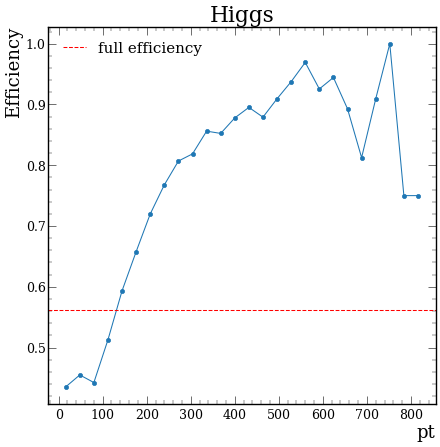

In [22]:
bin_means, bin_efficiency = pt_efficiency(higgs_true_pt, higgs_pred_pt, nbins=25, binwidth=32)
plt.plot(bin_means, bin_efficiency, marker='o')
plt.axhline(higgs_purities[-1], label="full efficiency", color='r', linestyle="--")
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.title("Higgs")
plt.legend()
plt.show()

In [28]:
data = pd.DataFrame({"pt": higgs_pred_pt})

bins = create_bins(lower_bound=0, width=32, quantity=25)
bin_means = []
for i in range(len(bins)):
    bin_means.append((bins[i][0] + bins[i][1])/2)

bins = pd.IntervalIndex.from_tuples(bins)
data['pt_bin'] = pd.cut(data['pt'], bins=bins)

a = data['pt_bin'].value_counts(sort=False)
a.index = a.index.astype(str)
a = a.to_dict()
all_counts = np.array(list(a.values()))

print("TOTAL COUNTS IN EACH BIN")
total_counts = data['pt_bin'].value_counts(sort=False)
data['pt_bin'].value_counts(sort=False) # TOTAL COUNTS IN EACH BIN

TOTAL COUNTS IN EACH BIN


(0, 32]        6689
(32, 64]      12617
(64, 96]      12361
(96, 128]      9610
(128, 160]     6958
(160, 192]     5009
(192, 224]     3759
(224, 256]     2850
(256, 288]     2191
(288, 320]     1583
(320, 352]     1237
(352, 384]      840
(384, 416]      606
(416, 448]      458
(448, 480]      331
(480, 512]      254
(512, 544]      160
(544, 576]      130
(576, 608]       94
(608, 640]       54
(640, 672]       28
(672, 704]       16
(704, 736]       22
(736, 768]        4
(768, 800]        4
(800, 832]        4
Name: pt_bin, dtype: int64

In [29]:
# Construct correctly predicted and wrongly predicted jet pts
mask = (higgs_true_pt == higgs_pred_pt)

# Find counts of correctly predicted events
data['correct'] = mask
data = data[data['correct']==True]

print("CORRECT COUNTS IN EACH BIN")
correct_counts = data['pt_bin'].value_counts(sort=False)
data['pt_bin'].value_counts(sort=False) # THE CORRECT COUNTS IN EACH BIN

CORRECT COUNTS IN EACH BIN


(0, 32]       2911
(32, 64]      5739
(64, 96]      5468
(96, 128]     4928
(128, 160]    4129
(160, 192]    3295
(192, 224]    2706
(224, 256]    2188
(256, 288]    1768
(288, 320]    1296
(320, 352]    1059
(352, 384]     716
(384, 416]     532
(416, 448]     410
(448, 480]     291
(480, 512]     231
(512, 544]     150
(544, 576]     126
(576, 608]      87
(608, 640]      51
(640, 672]      25
(672, 704]      13
(704, 736]      20
(736, 768]       4
(768, 800]       3
(800, 832]       3
Name: pt_bin, dtype: int64

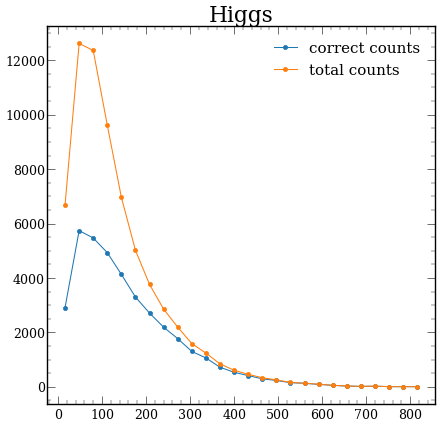

In [30]:
plt.plot(bin_means, correct_counts, marker='o', label="correct counts")
plt.plot(bin_means, all_counts, marker='o', label="total counts")
plt.title("Higgs")
plt.legend()
plt.show()

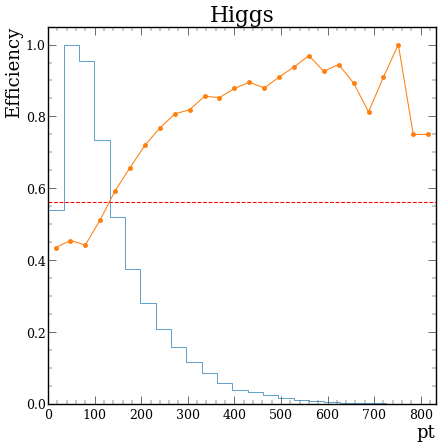

In [31]:
pred_pt = higgs_pred_pt[higgs_pred_pt <= 832]
pred_pt = pred_pt[pred_pt >= 0]
(counts, bins) = np.histogram(pred_pt, bins=25)
factor = 1/np.max(counts)
plt.hist(bins[:-1], bins, weights=factor*counts, histtype="step")
bin_means, bin_efficiency = pt_efficiency(higgs_true_pt, higgs_pred_pt, nbins=25, binwidth=32)
plt.plot(bin_means, bin_efficiency, marker='o')
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.title("Higgs")
plt.xlim(0,832)
plt.axhline(higgs_purities[-1], label="full efficiency", color='r', linestyle="--")
plt.show()

## Higgs efficiency by eta

In [32]:
higgs_true_eta = (higgs_jet_true[:,0] + higgs_jet_true[:,1]).eta
higgs_pred_eta = (higgs_jet_pred[:,0] + higgs_jet_pred[:,1]).eta

In [33]:
def eta_efficiency(true_eta, pred_eta, nbins, binwidth):
    
    # Bin the array of predicted etas
    data = pd.DataFrame({"eta": pred_eta})

    bins = create_bins(lower_bound=-4, width=binwidth, quantity=nbins)
    bin_means = []
    for i in range(len(bins)):
        bin_means.append((bins[i][0] + bins[i][1])/2)

    bins = pd.IntervalIndex.from_tuples(bins)
    data['eta_bin'] = pd.cut(data['eta'], bins=bins)
    
    # Find all counts (correctly and wrongly predicted -- denominator of efficiency)
    a = data['eta_bin'].value_counts(sort=False)
    a.index = a.index.astype(str)
    a = a.to_dict()
    all_counts = np.array(list(a.values()))
    
    # Construct correctly predicted and wrongly predicted jet pts
    mask = (true_eta == pred_eta)

    # Find counts of correctly predicted events
    data['correct'] = mask
    data = data[data['correct']==True]
    c = data['eta_bin'].value_counts(sort=False)
    c.index = c.index.astype(str)
    c = c.to_dict()
    correct_counts = np.array(list(c.values()))

    # Find the efficiency for each interval
    bin_efficiency = np.zeros(len(correct_counts))

    for i in range(len(all_counts)):
        if all_counts[i] > 0: # disregard empty bins and assign 0 efficiency to them
            bin_efficiency[i] = correct_counts[i]/all_counts[i]
        else:
            bin_efficiency[i] = 0
            
    return bin_means, bin_efficiency

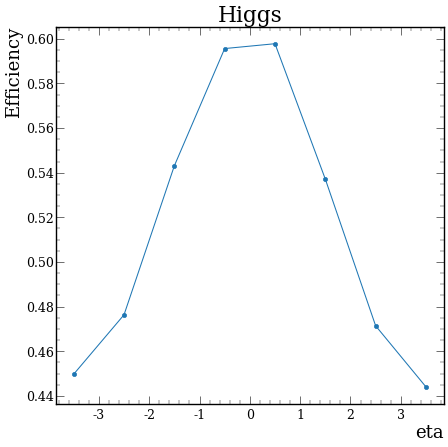

In [34]:
bin_means, bin_efficiency = eta_efficiency(higgs_true_eta, higgs_pred_eta, nbins=7, binwidth=1)
plt.plot(bin_means, bin_efficiency, marker='o')
plt.xlabel("eta")
plt.ylabel("Efficiency")
plt.title("Higgs")
plt.show()

## Higgs quark efficiency by quark pt

In [35]:
H_b1_true = ak.Array(df_input["TARGETS"]["h"]["b1"][()])
H_b1_true = ak.unflatten(H_b1_true, ak.ones_like(H_b1_true))
H_b1_pred = ak.Array(df["TARGETS"]["h"]["b1"][()])
H_b1_pred = ak.unflatten(H_b1_pred, ak.ones_like(H_b1_pred))

H_b1_jet_true = jets[H_b1_true]
H_b1_jet_pred = jets[H_b1_pred]

b1_true_pt = H_b1_jet_true.pt
b1_pred_pt = H_b1_jet_pred.pt

b1_true_pt = ak.flatten(b1_true_pt)
b1_pred_pt = ak.flatten(b1_pred_pt)

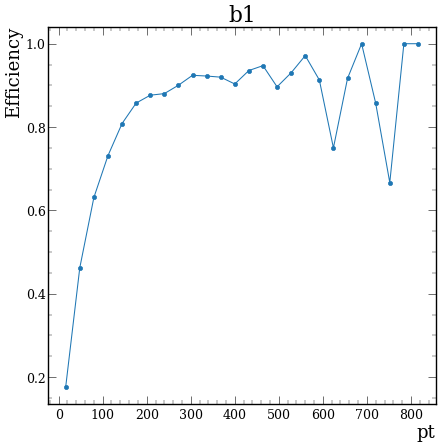

In [36]:
bin_means, bin_efficiency = pt_efficiency(b1_true_pt, b1_pred_pt, nbins=25, binwidth=32)
plt.plot(bin_means, bin_efficiency, marker='o')
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.title("b1")
plt.show()

In [37]:
H_b2_true = ak.Array(df_input["TARGETS"]["h"]["b2"][()])
H_b2_true = ak.unflatten(H_b2_true, ak.ones_like(H_b2_true))
H_b2_pred = ak.Array(df["TARGETS"]["h"]["b2"][()])
H_b2_pred = ak.unflatten(H_b2_pred, ak.ones_like(H_b2_pred))

H_b2_jet_true = jets[H_b2_true]
H_b2_jet_pred = jets[H_b2_pred]

b2_true_pt = H_b2_jet_true.pt
b2_pred_pt = H_b2_jet_pred.pt

b2_true_pt = ak.flatten(b2_true_pt)
b2_pred_pt = ak.flatten(b2_pred_pt)

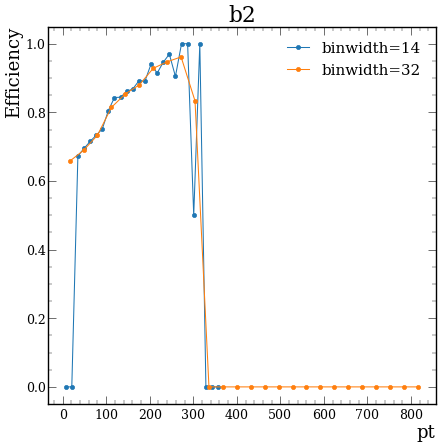

In [38]:
bin_means, bin_efficiency = pt_efficiency(b2_true_pt, b2_pred_pt, nbins=25, binwidth=14)
plt.plot(bin_means, bin_efficiency, marker='o', label="binwidth=14")
bin_means, bin_efficiency = pt_efficiency(b2_true_pt, b2_pred_pt, nbins=25, binwidth=32)
plt.plot(bin_means, bin_efficiency, marker='o', label="binwidth=32")
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.title("b2")
plt.legend()
plt.show()

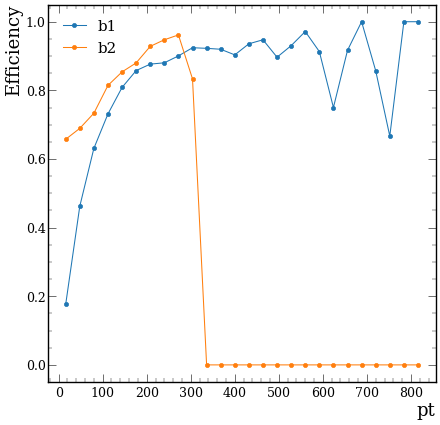

In [39]:
bin_means, bin_efficiency = pt_efficiency(b1_true_pt, b1_pred_pt, nbins=25, binwidth=32)
plt.plot(bin_means, bin_efficiency, marker='o', label="b1")
bin_means, bin_efficiency = pt_efficiency(b2_true_pt, b2_pred_pt, nbins=25, binwidth=32)
plt.plot(bin_means, bin_efficiency, marker='o', label="b2")
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.legend()
plt.show()

## Leptonic top efficiency by pt

In [40]:
t2_b_pred = ak.Array(df["TARGETS"]["t2"]["b"][()])
t2_b_pred = ak.unflatten(t2_b_pred, ak.ones_like(t2_b_pred))

t2_b_true = ak.Array(df_input["TARGETS"]["t2"]["b"][()])
t2_b_true = ak.unflatten(t2_b_true, ak.ones_like(t2_b_true))

leptop_index_pred = t2_b_pred
leptop_index_true = t2_b_true

leptop_jet_pred = jets[leptop_index_pred]
leptop_jet_true = jets[leptop_index_true]

leptop_pred_pt = leptop_jet_pred.pt
leptop_true_pt = leptop_jet_true.pt

leptop_pred_pt = ak.flatten(leptop_pred_pt)
leptop_true_pt = ak.flatten(leptop_true_pt)

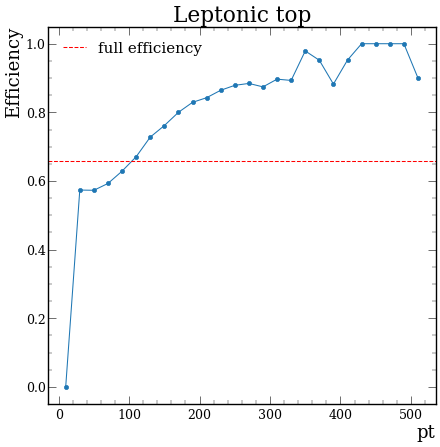

In [42]:
bin_means, bin_efficiency = pt_efficiency(leptop_true_pt, leptop_pred_pt, nbins=25, binwidth=20)
plt.plot(bin_means, bin_efficiency, marker='o')
plt.axhline(leptop_purities[-1], label="full efficiency", color='r', linestyle="--")
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.title("Leptonic top")
plt.legend()
plt.show()

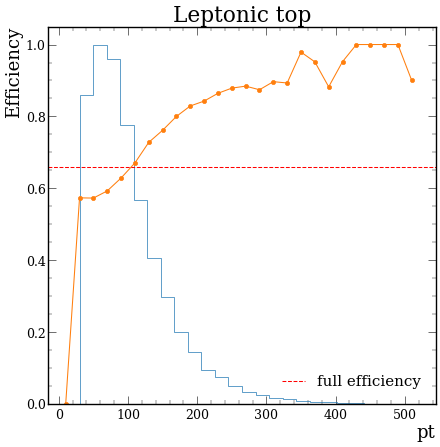

In [44]:
pred_pt = leptop_pred_pt[leptop_pred_pt <= 520]
pred_pt = pred_pt[pred_pt >= 0]
(counts, bins) = np.histogram(pred_pt, bins=25)
factor = 1/np.max(counts)
plt.hist(bins[:-1], bins, weights=factor*counts, histtype="step")

bin_means, bin_efficiency = pt_efficiency(leptop_true_pt, leptop_pred_pt, nbins=25, binwidth=20)
plt.plot(bin_means, bin_efficiency, marker='o')
plt.axhline(leptop_purities[-1], label="full efficiency", color='r', linestyle="--")
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.title("Leptonic top")
plt.legend(loc="lower right")
plt.show()

## Hadronic top efficiency by pt

In [45]:
t1_q1_true = ak.Array(df_input["TARGETS"]["t1"]["q1"][()])
t1_q2_true = ak.Array(df_input["TARGETS"]["t1"]["q2"][()])
t1_b_true = ak.Array(df_input["TARGETS"]["t1"]["b"][()])

t1_q1_true = ak.unflatten(t1_q1_true, ak.ones_like(t1_q1_true))
t1_q2_true = ak.unflatten(t1_q2_true, ak.ones_like(t1_q2_true))
t1_b_true = ak.unflatten(t1_b_true, ak.ones_like(t1_b_true))

t1_q1_pred = ak.Array(df["TARGETS"]["t1"]["q1"][()])
t1_q2_pred = ak.Array(df["TARGETS"]["t1"]["q2"][()])
t1_b_pred = ak.Array(df["TARGETS"]["t1"]["b"][()])

t1_q1_pred = ak.unflatten(t1_q1_pred, ak.ones_like(t1_q1_pred))
t1_q2_pred = ak.unflatten(t1_q2_pred, ak.ones_like(t1_q2_pred))
t1_b_pred = ak.unflatten(t1_b_pred, ak.ones_like(t1_b_pred))

hadtop_index_true = ak.concatenate((t1_q1_true, t1_q2_true, t1_b_true), axis=1)
hadtop_index_pred = ak.concatenate((t1_q1_pred, t1_q2_pred, t1_b_pred), axis=1)

hadtop_jet_true = jets[hadtop_index_true]
hadtop_jet_pred = jets[hadtop_index_pred]

hadtop_pred_pt = (hadtop_jet_pred[:,0] + hadtop_jet_pred[:,1] + hadtop_jet_pred[:,2]).pt
hadtop_true_pt = (hadtop_jet_true[:,0] + hadtop_jet_true[:,1] + hadtop_jet_true[:,2]).pt

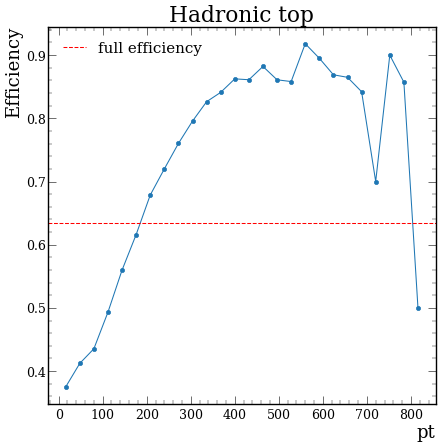

In [46]:
bin_means, bin_efficiency = pt_efficiency(hadtop_true_pt, hadtop_pred_pt, nbins=25, binwidth=32)
plt.plot(bin_means, bin_efficiency, marker='o')
plt.axhline(hadtop_purities[-1], label="full efficiency", color='r', linestyle="--")
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.title("Hadronic top")
plt.legend()
plt.show()

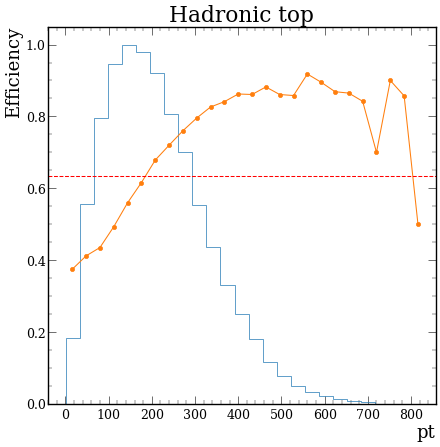

In [47]:
pred_pt = hadtop_pred_pt[hadtop_pred_pt <= 832]
pred_pt = pred_pt[pred_pt >= 0]
(counts, bins) = np.histogram(pred_pt, bins=25)
factor = 1/np.max(counts)
plt.hist(bins[:-1], bins, weights=factor*counts, histtype="step")

bin_means, bin_efficiency = pt_efficiency(hadtop_true_pt, hadtop_pred_pt, nbins=25, binwidth=32)
plt.plot(bin_means, bin_efficiency, marker='o')
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.title("Hadronic top")
plt.axhline(hadtop_purities[-1], label="full efficiency", color='r', linestyle="--")
plt.show()

## Dynamic binning

In [48]:
def pt_dynamic_efficiency(true_pt, pred_pt, nbins):
    
    # Bin the array of predicted pts
    data = pd.DataFrame({"pt": pred_pt})
    data['pt_bin'] = pd.qcut(data['pt'], q=nbins)
    
    bin_means = np.zeros(nbins)
    for i in range(nbins):
        bin_means[i] = data['pt_bin'].value_counts(sort=False).keys()[i].mid
    
    # Find all counts (correctly and wrongly predicted -- denominator of efficiency)
    a = data['pt_bin'].value_counts(sort=False)
    a.index = a.index.astype(str)
    a = a.to_dict()
    all_counts = np.array(list(a.values()))
    
    # Construct correctly predicted and wrongly predicted jet pts
    mask = (true_pt == pred_pt)

    # Find counts of correctly predicted events
    data['correct'] = mask
    data = data[data['correct']==True]
    c = data['pt_bin'].value_counts(sort=False)
    c.index = c.index.astype(str)
    c = c.to_dict()
    correct_counts = np.array(list(c.values()))

    # Find the efficiency for each interval
    bin_efficiency = np.zeros(len(correct_counts))

    for i in range(len(all_counts)):
        bin_efficiency[i] = correct_counts[i]/all_counts[i]
            
    return bin_means, bin_efficiency

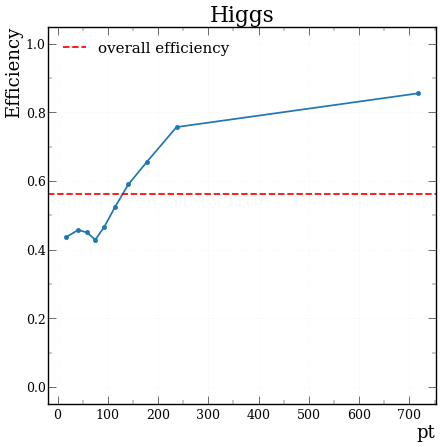

In [49]:
bin_means, bin_efficiency = pt_dynamic_efficiency(higgs_true_pt, higgs_pred_pt, nbins=10)

fig, ax = plt.subplots(1, 1)
plt.plot(bin_means, bin_efficiency, marker='o', linewidth=2.5)
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.title("Higgs")
plt.axhline(higgs_purities[-1], label="overall efficiency", color='r', linestyle="--", linewidth=2.5)
plt.ylim(-0.05,1.05)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(50))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
plt.legend(loc="upper left")
plt.grid(alpha=0.2, zorder=0)
plt.show()
#plt.rcParams['figure.facecolor'] = 'white'
#plt.savefig("./efficiency_plots/h_eff_vs_pt.png", transparent=False, dpi=300, bbox_inches='tight')

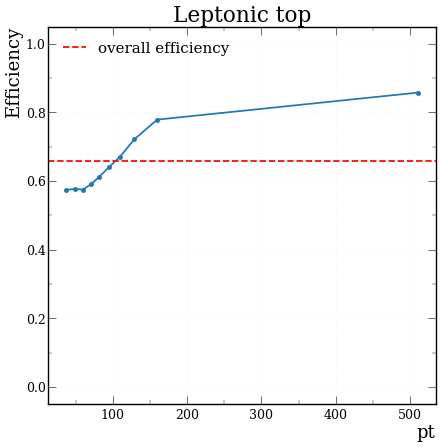

In [52]:
bin_means, bin_efficiency = pt_dynamic_efficiency(leptop_true_pt, leptop_pred_pt, nbins=10)

fig, ax = plt.subplots(1, 1)
plt.plot(bin_means, bin_efficiency, marker='o', linewidth=2.5)
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.title("Leptonic top")
plt.axhline(leptop_purities[-1], label="overall efficiency", color='r', linestyle="--", linewidth=2.5)
plt.ylim(-0.05,1.05)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(50))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
plt.legend(loc="upper left")
plt.grid(alpha=0.2, zorder=0)
plt.show()
#plt.rcParams['figure.facecolor'] = 'white'
#plt.savefig("./efficiency_plots/t2_eff_vs_pt.png", transparent=False, dpi=300, bbox_inches='tight')

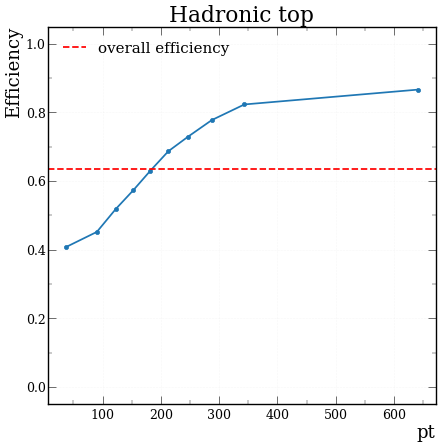

In [53]:
bin_means, bin_efficiency = pt_dynamic_efficiency(hadtop_true_pt, hadtop_pred_pt, nbins=10)

fig, ax = plt.subplots(1, 1)
plt.plot(bin_means, bin_efficiency, marker='o', linewidth=2.5)
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.title("Hadronic top")
plt.axhline(hadtop_purities[-1], label="overall efficiency", color='r', linestyle="--", linewidth=2.5)
plt.ylim(-0.05,1.05)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(50))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
plt.legend(loc="upper left")
plt.grid(alpha=0.2, zorder=0)
plt.show()
#plt.rcParams['figure.facecolor'] = 'white'
#plt.savefig("./efficiency_plots/t1_eff_vs_pt.png", transparent=False, dpi=300, bbox_inches='tight')

## All efficiencies

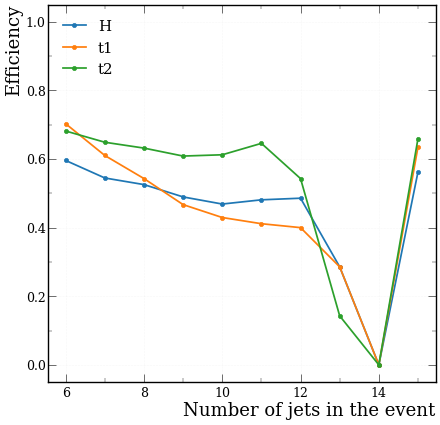

In [54]:
n = [6,7,8,9,10,11,12,13,14,"full"]

fig, ax = plt.subplots(1, 1)
plt.plot(n, higgs_purities, marker='o', label="H", linewidth=2.5)
plt.plot(n, hadtop_purities, marker='o', label="t1", linewidth=2.5)
plt.plot(n, leptop_purities, marker='o', label="t2", linewidth=2.5)

plt.xlabel("Number of jets in the event")
plt.ylabel("Efficiency")

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))

plt.legend(loc="upper left")
plt.grid(alpha=0.2, zorder=0)
plt.ylim(-0.05,1.05)
plt.show()
#plt.rcParams['figure.facecolor'] = 'white'
#plt.savefig("./efficiency_plots/eff_vs_njets.png", transparent=False, dpi=300, bbox_inches='tight')

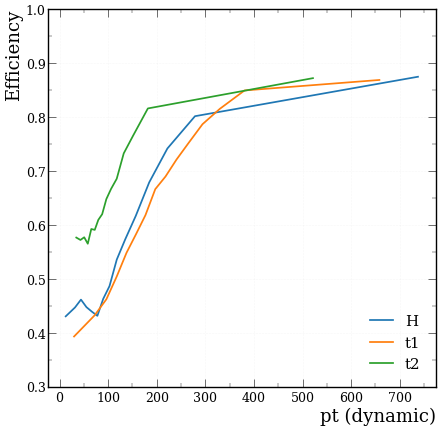

In [55]:
fig, ax = plt.subplots(1, 1)

bin_means, bin_efficiency = pt_dynamic_efficiency(higgs_true_pt, higgs_pred_pt, nbins=15)
plt.plot(bin_means, bin_efficiency, linewidth=2.5, label="H")
bin_means, bin_efficiency = pt_dynamic_efficiency(hadtop_true_pt, hadtop_pred_pt, nbins=15)
plt.plot(bin_means, bin_efficiency, linewidth=2.5, label="t1")
bin_means, bin_efficiency = pt_dynamic_efficiency(leptop_true_pt, leptop_pred_pt, nbins=15)
plt.plot(bin_means, bin_efficiency, linewidth=2.5, label="t2")

plt.xlabel("pt (dynamic)")
plt.ylabel("Efficiency")

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(50))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))

plt.legend(loc="lower right")
plt.grid(alpha=0.2, zorder=0)
plt.ylim(0.3,1)
plt.show()
#plt.rcParams['figure.facecolor'] = 'white'
#plt.savefig("./efficiency_plots/eff_vs_pt.png", transparent=False, dpi=300, bbox_inches='tight')

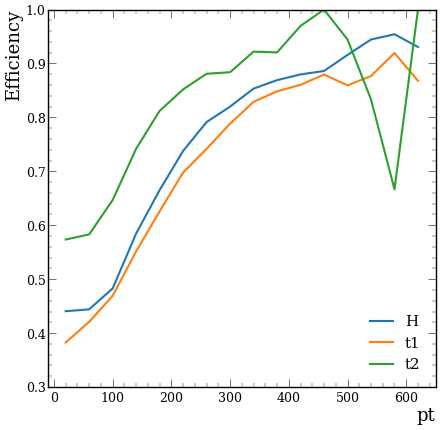

In [56]:
bin_means, bin_efficiency = pt_efficiency(higgs_true_pt, higgs_pred_pt,
                                          nbins=15, binwidth=40)
plt.plot(bin_means, bin_efficiency, linewidth=3, label="H")
bin_means, bin_efficiency = pt_efficiency(hadtop_true_pt, hadtop_pred_pt,
                                          nbins=15, binwidth=40)
plt.plot(bin_means, bin_efficiency, linewidth=3, label="t1")
bin_means, bin_efficiency = pt_efficiency(leptop_true_pt, leptop_pred_pt,
                                          nbins=15, binwidth=40)
plt.plot(bin_means, bin_efficiency, linewidth=3, label="t2")
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.ylim(0.3,1)
plt.legend(loc="lower right")
plt.show()

## Plots with errorbars

$\text{efficiency}=\frac{\text{correct counts in bin}}{\text{all counts in bin}}$

Error on efficiency is Poisson error:

$\text{error}=\frac{\text{efficiency(1-efficiency)}}{\text{all counts in bin}}$

### Higgs

In [57]:
nbins=20
binwidth=32

data = pd.DataFrame({"pt": higgs_pred_pt})

bins = create_bins(lower_bound=0, width=binwidth, quantity=nbins)
bin_means = []
for i in range(len(bins)):
    bin_means.append((bins[i][0] + bins[i][1])/2)

bins = pd.IntervalIndex.from_tuples(bins)
data['pt_bin'] = pd.cut(data['pt'], bins=bins)

a = data['pt_bin'].value_counts(sort=False) # THE TOTAL COUNTS IN EACH BIN
a.index = a.index.astype(str)
a = a.to_dict()
all_counts = np.array(list(a.values()))

error_all_counts = np.sqrt(all_counts)

#print(all_counts)
#print(error_all_counts)

mask = (higgs_true_pt == higgs_pred_pt)
data['correct'] = mask
data = data[data['correct']==True]

a = data['pt_bin'].value_counts(sort=False) # THE CORRECT COUNTS IN EACH BIN
a.index = a.index.astype(str)
a = a.to_dict()
correct_counts = np.array(list(a.values()))

error_correct_counts = np.sqrt(correct_counts)

#print(correct_counts)
#print(error_correct_counts)

# For now only include Poisson error
bin_efficiency = np.zeros(len(correct_counts))
error_efficiency = np.zeros(len(bin_efficiency))

for i in range(len(all_counts)):
    bin_efficiency[i] = correct_counts[i]/all_counts[i]
    error_efficiency[i] = np.sqrt(bin_efficiency[i]*(1-bin_efficiency[i])/all_counts[i])

#print(error_efficiency)

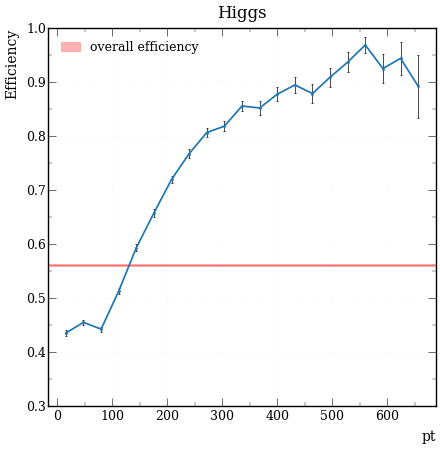

In [58]:
purity = higgs_purities[-1]
error = higgs_errors[-1]

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

fig, ax = plt.subplots(1, 1)
plt.errorbar(bin_means, bin_efficiency, error_efficiency,
             marker='.', ecolor='k', elinewidth=1, capsize=1.6, linewidth=2.5)

plt.axhspan(purity + error, purity, color='r', alpha=0.3,
            label="overall efficiency")
plt.axhspan(purity - error, purity, color='r', alpha=0.3)

plt.xlabel("pt", fontsize=20, labelpad=10)
plt.ylabel("Efficiency", fontsize=20, labelpad=10)
plt.title("Higgs", fontsize=24, pad=15)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(50))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))

plt.grid(alpha=0.2, zorder=0)
plt.ylim(0.3,1)
plt.legend(loc="upper left", fontsize=18)
plt.show()
#plt.rcParams['figure.facecolor'] = 'white'
#plt.savefig("./efficiency_plots/h_eff_vs_pt_errors_band.png", transparent=False, dpi=300, bbox_inches='tight')

In [59]:
nbins = 20
data = pd.DataFrame({"pt": higgs_pred_pt})
data['pt_bin'] = pd.qcut(data['pt'], q=nbins)

bin_means = np.zeros(nbins)
for i in range(nbins):
    bin_means[i] = data['pt_bin'].value_counts(sort=False).keys()[i].mid

a = data['pt_bin'].value_counts(sort=False)
a.index = a.index.astype(str)
a = a.to_dict()
all_counts = np.array(list(a.values()))

mask = (higgs_true_pt == higgs_pred_pt)
data['correct'] = mask
data = data[data['correct']==True]
c = data['pt_bin'].value_counts(sort=False)
c.index = c.index.astype(str)
c = c.to_dict()
correct_counts = np.array(list(c.values()))

# For now only include Poisson error
bin_efficiency = np.zeros(len(correct_counts))
error_efficiency = np.zeros(len(bin_efficiency))

for i in range(len(all_counts)):
    bin_efficiency[i] = correct_counts[i]/all_counts[i]

for i in range(len(all_counts)):
    bin_efficiency[i] = correct_counts[i]/all_counts[i]
    error_efficiency[i] = np.sqrt(bin_efficiency[i]*(1-bin_efficiency[i])/all_counts[i])

#print(error_efficiency)

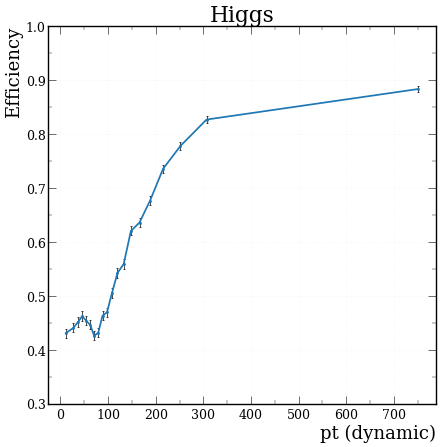

In [60]:
fig, ax = plt.subplots(1, 1)
plt.errorbar(bin_means, bin_efficiency, error_efficiency,
             marker='.', ecolor='k', elinewidth=1, capsize=1.6, linewidth=2.5)
plt.xlabel("pt (dynamic)")
plt.ylabel("Efficiency")
plt.title("Higgs")

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(50))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))

plt.grid(alpha=0.2, zorder=0)
plt.ylim(0.3,1)
plt.show()
#plt.rcParams['figure.facecolor'] = 'white'
#plt.savefig("./efficiency_plots/h_eff_vs_pt_errors_dynamic.png", transparent=False, dpi=300, bbox_inches='tight')

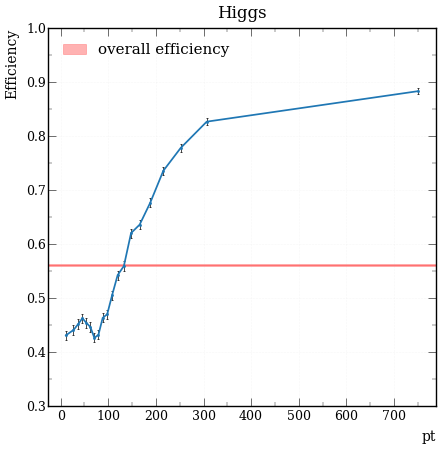

In [61]:
purity = higgs_purities[-1]
error = higgs_errors[-1]

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

# Plot it with an uncertainty band around overall efficiency
fig, ax = plt.subplots(1, 1)
plt.errorbar(bin_means, bin_efficiency, error_efficiency,
             marker='.', ecolor='k', elinewidth=1, capsize=1.6, linewidth=2.5)

plt.axhspan(purity + error, purity, color='r', alpha=0.3,
            label="overall efficiency")
plt.axhspan(purity - error, purity, color='r', alpha=0.3)

plt.xlabel("pt", fontsize=20, labelpad=10)
plt.ylabel("Efficiency", fontsize=20, labelpad=10)
plt.title("Higgs", fontsize=24, pad=15)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(50))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))

plt.grid(alpha=0.2, zorder=0)
plt.ylim(0.3,1)
plt.legend(loc="upper left")
plt.show()
#plt.rcParams['figure.facecolor'] = 'white'
#plt.savefig("./efficiency_plots/h_eff_vs_pt_errors_dynamic_band.png", transparent=False, dpi=300, bbox_inches='tight')

### Leptonic top

In [73]:
nbins=20
binwidth=20

data = pd.DataFrame({"pt": leptop_pred_pt})

bins = create_bins(lower_bound=0, width=binwidth, quantity=nbins)
bin_means = []
for i in range(len(bins)):
    bin_means.append((bins[i][0] + bins[i][1])/2)

bins = pd.IntervalIndex.from_tuples(bins)
data['pt_bin'] = pd.cut(data['pt'], bins=bins)

a = data['pt_bin'].value_counts(sort=False) # THE TOTAL COUNTS IN EACH BIN
a.index = a.index.astype(str)
a = a.to_dict()
all_counts = np.array(list(a.values()))

mask = (leptop_true_pt == leptop_pred_pt)
data['correct'] = mask
data = data[data['correct']==True]

a = data['pt_bin'].value_counts(sort=False) # THE CORRECT COUNTS IN EACH BIN
a.index = a.index.astype(str)
a = a.to_dict()
correct_counts = np.array(list(a.values()))

# For now only include Poisson error
bin_efficiency = np.zeros(len(correct_counts))
error_efficiency = np.zeros(len(bin_efficiency))

for i in range(len(all_counts)):
    bin_efficiency[i] = correct_counts[i]/all_counts[i]
    error_efficiency[i] = np.sqrt(bin_efficiency[i]*(1-bin_efficiency[i])/all_counts[i])
#print(error_efficiency)

/tmp/ipykernel_1382/26698502.py:33: RuntimeWarning: invalid value encountered in long_scalars
  bin_efficiency[i] = correct_counts[i]/all_counts[i]


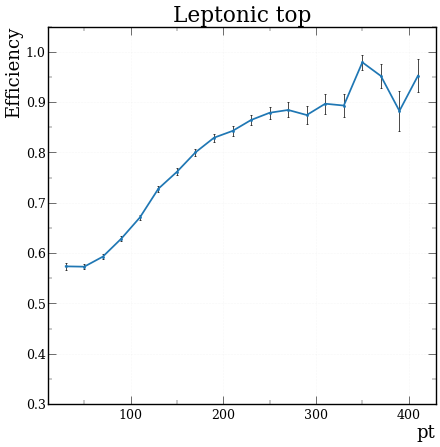

In [64]:
fig, ax = plt.subplots(1, 1)
plt.errorbar(bin_means, bin_efficiency, error_efficiency,
             marker='.', ecolor='k', elinewidth=1, capsize=1.6, linewidth=2.5)
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.title("Leptonic top")

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(50))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))

plt.grid(alpha=0.2, zorder=0)
plt.ylim(0.3,1.05)
plt.show()
#plt.rcParams['figure.facecolor'] = 'white'
#plt.savefig("./efficiency_plots/t2_eff_vs_pt_errors.png", transparent=False, dpi=300, bbox_inches='tight')

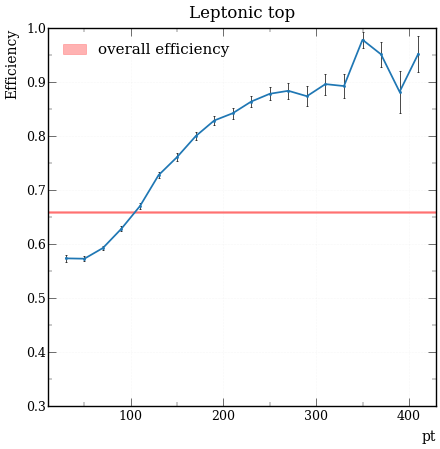

In [65]:
purity = leptop_purities[-1]
error = leptop_errors[-1]

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

# Plot it with an uncertainty band around overall efficiency
fig, ax = plt.subplots(1, 1)
plt.errorbar(bin_means, bin_efficiency, error_efficiency,
             marker='.', ecolor='k', elinewidth=1, capsize=1.6, linewidth=2.5)
#plt.axhline(full_purity, color='r', linestyle='--', linewidth=2.5)
plt.axhspan(purity + error, purity, color='r', alpha=0.3,
            label="overall efficiency")
plt.axhspan(purity - error, purity, color='r', alpha=0.3)

plt.xlabel("pt", fontsize=20, labelpad=10)
plt.ylabel("Efficiency", fontsize=20, labelpad=10)
plt.title("Leptonic top", fontsize=24, pad=15)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(50))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))

plt.grid(alpha=0.2, zorder=0)
plt.ylim(0.3,1)
plt.legend(loc="upper left")
plt.show()
#plt.rcParams['figure.facecolor'] = 'white'
#plt.savefig("./efficiency_plots/t2_eff_vs_pt_errors_band.png", transparent=False, dpi=300, bbox_inches='tight')

In [66]:
nbins = 20
data = pd.DataFrame({"pt": leptop_pred_pt})
data['pt_bin'] = pd.qcut(data['pt'], q=nbins)

bin_means = np.zeros(nbins)
for i in range(nbins):
    bin_means[i] = data['pt_bin'].value_counts(sort=False).keys()[i].mid

a = data['pt_bin'].value_counts(sort=False)
a.index = a.index.astype(str)
a = a.to_dict()
all_counts = np.array(list(a.values()))

mask = (leptop_true_pt == leptop_pred_pt)
data['correct'] = mask
data = data[data['correct']==True]
c = data['pt_bin'].value_counts(sort=False)
c.index = c.index.astype(str)
c = c.to_dict()
correct_counts = np.array(list(c.values()))

# For now only include Poisson error
bin_efficiency = np.zeros(len(correct_counts))
error_efficiency = np.zeros(len(bin_efficiency))

for i in range(len(all_counts)):
    bin_efficiency[i] = correct_counts[i]/all_counts[i]

for i in range(len(all_counts)):
    bin_efficiency[i] = correct_counts[i]/all_counts[i]
    error_efficiency[i] = np.sqrt(bin_efficiency[i]*(1-bin_efficiency[i])/all_counts[i])

#print(error_efficiency)

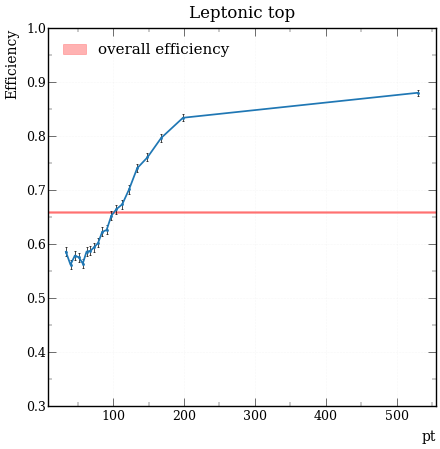

In [67]:
purity = leptop_purities[-1]
error = leptop_errors[-1]

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

# Plot it with an uncertainty band around overall efficiency
fig, ax = plt.subplots(1, 1)
plt.errorbar(bin_means, bin_efficiency, error_efficiency,
             marker='.', ecolor='k', elinewidth=1, capsize=1.6, linewidth=2.5)
#plt.axhline(full_purity, color='r', linestyle='--', linewidth=2.5)
plt.axhspan(purity + error, purity, color='r', alpha=0.3,
            label="overall efficiency")
plt.axhspan(purity - error, purity, color='r', alpha=0.3)

plt.xlabel("pt", fontsize=20, labelpad=10)
plt.ylabel("Efficiency", fontsize=20, labelpad=10)
plt.title("Leptonic top", fontsize=24, pad=15)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(50))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))

plt.grid(alpha=0.2, zorder=0)
plt.ylim(0.3,1)
plt.legend(loc="upper left")
plt.show()
#plt.rcParams['figure.facecolor'] = 'white'
#plt.savefig("./efficiency_plots/t2_eff_vs_pt_errors_dynamic_band.png", transparent=False, dpi=300, bbox_inches='tight')

### Hadronic top

In [68]:
nbins=24
binwidth=32

data = pd.DataFrame({"pt": hadtop_pred_pt})

bins = create_bins(lower_bound=0, width=binwidth, quantity=nbins)
bin_means = []
for i in range(len(bins)):
    bin_means.append((bins[i][0] + bins[i][1])/2)

bins = pd.IntervalIndex.from_tuples(bins)
data['pt_bin'] = pd.cut(data['pt'], bins=bins)

a = data['pt_bin'].value_counts(sort=False) # THE TOTAL COUNTS IN EACH BIN
a.index = a.index.astype(str)
a = a.to_dict()
all_counts = np.array(list(a.values()))

mask = (hadtop_true_pt == hadtop_pred_pt)
data['correct'] = mask
data = data[data['correct']==True]

a = data['pt_bin'].value_counts(sort=False) # THE CORRECT COUNTS IN EACH BIN
a.index = a.index.astype(str)
a = a.to_dict()
correct_counts = np.array(list(a.values()))

# For now only include Poisson error
bin_efficiency = np.zeros(len(correct_counts))
error_efficiency = np.zeros(len(bin_efficiency))

for i in range(len(all_counts)):
    bin_efficiency[i] = correct_counts[i]/all_counts[i]
    error_efficiency[i] = np.sqrt(bin_efficiency[i]*(1-bin_efficiency[i])/all_counts[i])
#print(error_efficiency)

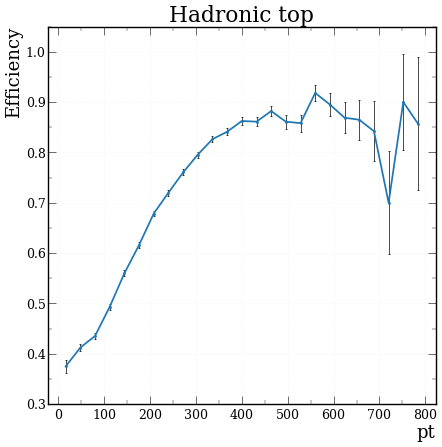

In [69]:
fig, ax = plt.subplots(1, 1)
plt.errorbar(bin_means, bin_efficiency, error_efficiency,
             marker='.', ecolor='k', elinewidth=1, capsize=1.6, linewidth=2.5)
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.title("Hadronic top")

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(50))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))

plt.grid(alpha=0.2, zorder=0)
plt.ylim(0.3,1.05)
plt.show()
#plt.rcParams['figure.facecolor'] = 'white'
#plt.savefig("./efficiency_plots/t1_eff_vs_pt_errors.png", transparent=False, dpi=300, bbox_inches='tight')

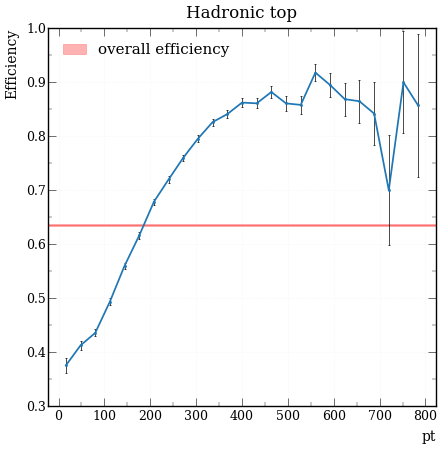

In [70]:
purity = hadtop_purities[-1]
error = hadtop_errors[-1]

# Plot it with an uncertainty band around overall efficiency
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

fig, ax = plt.subplots(1, 1)

# Plot it with an uncertainty band around overall efficiency
plt.errorbar(bin_means, bin_efficiency, error_efficiency,
             marker='.', ecolor='k', elinewidth=1, capsize=1.6, linewidth=2.5)
#plt.axhline(full_purity, color='r', linestyle='--', linewidth=2.5)
plt.axhspan(purity + error, purity, color='r', alpha=0.3,
            label="overall efficiency")
plt.axhspan(purity - error, purity, color='r', alpha=0.3)

plt.xlabel("pt", fontsize=20, labelpad=10)
plt.ylabel("Efficiency", fontsize=20, labelpad=10)
plt.title("Hadronic top", fontsize=24, pad=15)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(50))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))

plt.grid(alpha=0.2, zorder=0)
plt.ylim(0.3,1)
plt.legend(loc="upper left")
#plt.show()
plt.rcParams['figure.facecolor'] = 'white'
plt.savefig("./efficiency_plots/t1_eff_vs_pt_errors_band.png", transparent=False, dpi=300, bbox_inches='tight')

In [71]:
nbins = 20
data = pd.DataFrame({"pt": hadtop_pred_pt})
data['pt_bin'] = pd.qcut(data['pt'], q=nbins)

bin_means = np.zeros(nbins)
for i in range(nbins):
    bin_means[i] = data['pt_bin'].value_counts(sort=False).keys()[i].mid

a = data['pt_bin'].value_counts(sort=False)
a.index = a.index.astype(str)
a = a.to_dict()
all_counts = np.array(list(a.values()))

mask = (hadtop_true_pt == hadtop_pred_pt)
data['correct'] = mask
data = data[data['correct']==True]
c = data['pt_bin'].value_counts(sort=False)
c.index = c.index.astype(str)
c = c.to_dict()
correct_counts = np.array(list(c.values()))

# For now only include Poisson error
bin_efficiency = np.zeros(len(correct_counts))
error_efficiency = np.zeros(len(bin_efficiency))

for i in range(len(all_counts)):
    bin_efficiency[i] = correct_counts[i]/all_counts[i]

for i in range(len(all_counts)):
    bin_efficiency[i] = correct_counts[i]/all_counts[i]
    error_efficiency[i] = np.sqrt(bin_efficiency[i]*(1-bin_efficiency[i])/all_counts[i])

#print(error_efficiency)

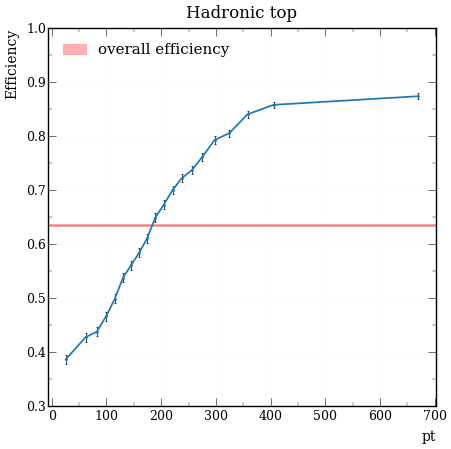

In [72]:
purity = hadtop_purities[-1]
error = hadtop_errors[-1]

# Plot it with an uncertainty band around overall efficiency
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

fig, ax = plt.subplots(1, 1)

plt.errorbar(bin_means, bin_efficiency, error_efficiency,
             marker='.', ecolor='k', elinewidth=1, capsize=1.6, linewidth=2.5)
#plt.axhline(full_purity, color='r', linestyle='--', linewidth=2.5)
plt.axhspan(purity + error, purity, color='r', alpha=0.3,
            label="overall efficiency")
plt.axhspan(purity - error, purity, color='r', alpha=0.3)

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(50))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))

plt.xlabel("pt", fontsize=20, labelpad=10)
plt.ylabel("Efficiency", fontsize=20, labelpad=10)
plt.title("Hadronic top", fontsize=24, pad=15)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.grid(alpha=0.2, zorder=0)
plt.ylim(0.3,1)
plt.legend(loc="upper left")
plt.show()
#plt.rcParams['figure.facecolor'] = 'white'
#plt.savefig("./efficiency_plots/t1_eff_vs_pt_errors_dynamic_band.png", transparent=False, dpi=300, bbox_inches='tight')